데이터 로드 중...
학습 데이터 크기: (87159, 16)
테스트 데이터 크기: (46204, 15)
제출 샘플 크기: (46204, 2)
\n결측치 확인:
ID                   0
Age                  0
Gender               0
Country              0
Race                 0
Family_Background    0
Radiation_History    0
Iodine_Deficiency    0
Smoke                0
Weight_Risk          0
Diabetes             0
Nodule_Size          0
TSH_Result           0
T4_Result            0
T3_Result            0
Cancer               0
dtype: int64
\n타겟 변수(Cancer) 분포:
Cancer
0    76700
1    10459
Name: count, dtype: int64
암 양성 비율: 12.00%
\n데이터 전처리 진행 중...


/var/folders/bj/ljbr3v1s4vg1cjjtmtss7w3r0000gn/T/ipykernel_59024/1517270792.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_encoded['Cancer'] = train_df['Cancer']
/var/folders/bj/ljbr3v1s4vg1cjjtmtss7w3r0000gn/T/ipykernel_59024/1517270792.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_encoded['Iodine_Country_Risk'] = (train_df_encoded[iodine_def_col[0]] == 1) & (train_df_encoded[country_ind_col[0]] == 1).astype(int)
/var/folders/bj/ljbr3v1s4vg1cjjtmtss7w3r0000gn/T/ipykernel_59

\n원-핫 인코딩 후 범주형 변수: ['Weight_Risk_Not Obese', 'Gender_M', 'Smoke_Smoker', 'Country_IND', 'Race_HSP', 'Country_GBR', 'Race_MDE', 'Country_RUS', 'Radiation_History_Unexposed', 'Country_CHN', 'Country_KOR', 'Country_NGA', 'Country_DEU', 'Race_CAU', 'Family_Background_Negative', 'Country_BRA', 'Family_Background_Positive', 'Smoke_Non-Smoker', 'Diabetes_Yes', 'Country_USA', 'Radiation_History_Exposed', 'Country_JPN', 'Iodine_Deficiency_Deficient', 'Iodine_Deficiency_Sufficient', 'Race_AFR', 'Diabetes_No', 'Weight_Risk_Obese', 'Gender_F', 'Race_ASN']
수치형 변수: ['Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result']
\n특성 엔지니어링 진행 중...
특성 'Age_Squared' 생성 완료.
\nStandardScaler 적용 중...
학습 데이터 크기: (69727, 39)
검증 데이터 크기: (17432, 39)
\nPyTorch 모델 학습 시작...
Using device: cpu
Epoch [1/200], Train Loss: 0.0425, Val Loss: 0.0412, Val F1: 0.4686, LR: 0.001000
New best model found! Val F1: 0.4686
Epoch [2/200], Train Loss: 0.0407, Val Loss: 0.0407, Val F1: 0.4686, LR: 0.001000
Epoch [3/200], Train Lo

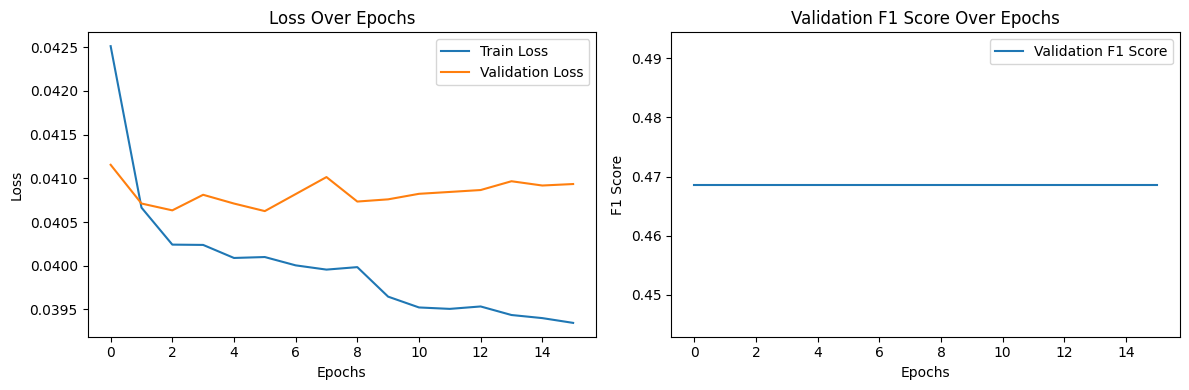

\n테스트 데이터에 예측 중...
\n예측 완료! 'pytorch_submission.csv' 파일에 결과가 저장되었습니다.
예측 결과 분포:
Cancer
0    40448
1     5756
Name: count, dtype: int64
암 양성 예측 비율: 12.46%
\n분석 완료!


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Focal Loss 정의
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets = targets.float().unsqueeze(1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - p_t)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# PyTorch Dataset 정의
class CancerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)

# 간단한 MLP 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, output_dim=1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) # 드롭아웃 추가
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3) # 드롭아웃 추가
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# 데이터 로드
print("데이터 로드 중...")
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
sample_submission = pd.read_csv('../sample_submission.csv')

print(f"학습 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")
print(f"제출 샘플 크기: {sample_submission.shape}")

# 기본적인 데이터 정보 확인
# print("\\n학습 데이터 정보:")
# print(train_df.info()) # 너무 길어서 주석 처리

print("\\n결측치 확인:")
print(train_df.isnull().sum())

# 타겟 변수 분포 확인
print("\\n타겟 변수(Cancer) 분포:")
print(train_df['Cancer'].value_counts())
print(f"암 양성 비율: {train_df['Cancer'].mean() * 100:.2f}%")

# 1. 데이터 전처리
print("\\n데이터 전처리 진행 중...")

# ID 열 drop
train_df_processed = train_df.drop('ID', axis=1)
test_df_processed = test_df.drop('ID', axis=1)

# 범주형(문자열) 변수와 수치형 변수 분리
categorical_cols = train_df_processed.select_dtypes(include=['object']).columns
numerical_cols = train_df_processed.drop('Cancer', axis=1).select_dtypes(include=[np.number]).columns

# 원-핫 인코딩을 위해 학습 데이터와 테스트 데이터를 합쳤다가 다시 분리
combined_df = pd.concat([train_df_processed.drop('Cancer', axis=1), test_df_processed], keys=['train', 'test'])
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols, dummy_na=False)

train_df_encoded = combined_df_encoded.loc['train']
test_df_encoded = combined_df_encoded.loc['test']

# 타겟 변수 다시 추가
train_df_encoded['Cancer'] = train_df['Cancer']


print(f"\\n원-핫 인코딩 후 범주형 변수: {list(set(train_df_encoded.columns) - set(numerical_cols) - set(['Cancer']))}")
print(f"수치형 변수: {list(numerical_cols)}")


# 2. 간단한 특성 엔지니어링 (원-핫 인코딩 이후 수행하도록 수정)
print("\\n특성 엔지니어링 진행 중...")

# Iodine_Deficiency 와 Country 관련 열 이름 확인 (원-핫 인코딩으로 변경됨)
# 예를 들어 Iodine_Deficiency_Deficient, Country_IND 등으로 변경되었을 것임
# 해당 열들이 존재하는지 확인하고 특성 생성
iodine_def_col = [col for col in train_df_encoded.columns if 'Iodine_Deficiency_Deficient' in col]
country_ind_col = [col for col in train_df_encoded.columns if 'Country_IND' in col]

if iodine_def_col and country_ind_col:
    train_df_encoded['Iodine_Country_Risk'] = (train_df_encoded[iodine_def_col[0]] == 1) & (train_df_encoded[country_ind_col[0]] == 1).astype(int)
    test_df_encoded['Iodine_Country_Risk'] = (test_df_encoded[iodine_def_col[0]] == 1) & (test_df_encoded[country_ind_col[0]] == 1).astype(int)
    if 'Iodine_Country_Risk' not in numerical_cols: # 수치형 변수 목록에 추가
        numerical_cols = numerical_cols.append(pd.Index(['Iodine_Country_Risk']))
else:
    print("Warning: Iodine_Deficiency_Deficient 또는 Country_IND 열을 찾을 수 없어 Iodine_Country_Risk 특성을 생성하지 못했습니다.")
    # 이 경우, Iodine_Country_Risk 열이 없으므로 이후 코드에서 참조하지 않도록 주의 필요
    # 또는 기본값(0)으로 채울 수 있음
    train_df_encoded['Iodine_Country_Risk'] = 0
    test_df_encoded['Iodine_Country_Risk'] = 0
    if 'Iodine_Country_Risk' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Iodine_Country_Risk']))

# Age와 Tumor_Size 상호작용 특성 추가
if 'Age' in train_df_encoded.columns and 'Tumor_Size' in train_df_encoded.columns:
    train_df_encoded['Age_Tumor_Interaction'] = train_df_encoded['Age'] * train_df_encoded['Tumor_Size']
    test_df_encoded['Age_Tumor_Interaction'] = test_df_encoded['Age'] * test_df_encoded['Tumor_Size']
    if 'Age_Tumor_Interaction' not in numerical_cols:
        # numerical_cols가 Pandas Index 객체이므로 append를 사용하고 다시 할당
        numerical_cols = numerical_cols.append(pd.Index(['Age_Tumor_Interaction']))
    print("특성 'Age_Tumor_Interaction' 생성 완료.")
else:
    print("Warning: 'Age' 또는 'Tumor_Size' 열을 찾을 수 없어 'Age_Tumor_Interaction' 특성을 생성하지 못했습니다.")
    # 특성 생성 실패 시 해당 열이 없을 수 있으므로 기본값으로 채우고 numerical_cols에 추가
    train_df_encoded['Age_Tumor_Interaction'] = 0
    test_df_encoded['Age_Tumor_Interaction'] = 0
    if 'Age_Tumor_Interaction' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Age_Tumor_Interaction']))

# Polynomial features for Age and Tumor_Size
# Age_Squared
if 'Age' in train_df_encoded.columns and 'Age' in numerical_cols:
    train_df_encoded['Age_Squared'] = train_df_encoded['Age'] ** 2
    if 'Age' in test_df_encoded.columns:
        test_df_encoded['Age_Squared'] = test_df_encoded['Age'] ** 2
    else:
        test_df_encoded['Age_Squared'] = 0
        print("Warning: 'Age' column not found in test_df_encoded for 'Age_Squared'. Filled with 0.")

    if 'Age_Squared' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Age_Squared']))
    print("특성 'Age_Squared' 생성 완료.")
else:
    print("Warning: 'Age' 열을 찾을 수 없거나 numeric이 아니어서 'Age_Squared' 특성을 생성하지 못했습니다.")
    train_df_encoded['Age_Squared'] = 0
    if 'Age' in test_df_encoded.columns:
        test_df_encoded['Age_Squared'] = 0
    else:
        test_df_encoded['Age_Squared'] = 0
    if 'Age_Squared' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Age_Squared']))

# Tumor_Size_Squared
if 'Tumor_Size' in train_df_encoded.columns and 'Tumor_Size' in numerical_cols:
    train_df_encoded['Tumor_Size_Squared'] = train_df_encoded['Tumor_Size'] ** 2
    if 'Tumor_Size' in test_df_encoded.columns:
        test_df_encoded['Tumor_Size_Squared'] = test_df_encoded['Tumor_Size'] ** 2
    else:
        test_df_encoded['Tumor_Size_Squared'] = 0
        print("Warning: 'Tumor_Size' column not found in test_df_encoded for 'Tumor_Size_Squared'. Filled with 0.")

    if 'Tumor_Size_Squared' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Tumor_Size_Squared']))
    print("특성 'Tumor_Size_Squared' 생성 완료.")
else:
    print("Warning: 'Tumor_Size' 열을 찾을 수 없거나 numeric이 아니어서 'Tumor_Size_Squared' 특성을 생성하지 못했습니다.")
    train_df_encoded['Tumor_Size_Squared'] = 0
    if 'Tumor_Size' in test_df_encoded.columns:
        test_df_encoded['Tumor_Size_Squared'] = 0
    else:
        test_df_encoded['Tumor_Size_Squared'] = 0
    if 'Tumor_Size_Squared' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Tumor_Size_Squared']))

# Smoking and Hx_Radiothreapy Interaction
smoking_indicator_col = None
radiotherapy_indicator_col = None

possible_smoking_origins = ['Smoking', 'smoking']
potential_smoking_col_suffixes = ["_Yes", "_yes", "_True", "_true", "_1", "_Current", "_Active"]
for orig_smk_name in possible_smoking_origins:
    for suffix in potential_smoking_col_suffixes:
        col_name = f"{orig_smk_name}{suffix}"
        if col_name in train_df_encoded.columns:
            smoking_indicator_col = col_name
            break
    if smoking_indicator_col:
        break

possible_radiotherapy_origins = ['Hx_Radiothreapy', 'Hx_Radiotherapy', 'Radiotherapy', 'Radiothreapy']
potential_radiotherapy_col_suffixes = ["_Yes", "_yes", "_True", "_true", "_1"]
for orig_rt_name in possible_radiotherapy_origins:
    for suffix in potential_radiotherapy_col_suffixes:
        col_name = f"{orig_rt_name}{suffix}"
        if col_name in train_df_encoded.columns:
            radiotherapy_indicator_col = col_name
            break
    if radiotherapy_indicator_col:
        break

if smoking_indicator_col and radiotherapy_indicator_col:
    train_df_encoded['Smoking_Radiotherapy_Interaction'] = train_df_encoded[smoking_indicator_col] * train_df_encoded[radiotherapy_indicator_col]
    if smoking_indicator_col in test_df_encoded.columns and radiotherapy_indicator_col in test_df_encoded.columns:
         test_df_encoded['Smoking_Radiotherapy_Interaction'] = test_df_encoded[smoking_indicator_col] * test_df_encoded[radiotherapy_indicator_col]
    else:
        print(f"Warning: One or both of {smoking_indicator_col}, {radiotherapy_indicator_col} not in test set for Smoking_Radiotherapy_Interaction. Filling with 0.")
        test_df_encoded['Smoking_Radiotherapy_Interaction'] = 0

    if 'Smoking_Radiotherapy_Interaction' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Smoking_Radiotherapy_Interaction']))
    print(f"특성 'Smoking_Radiotherapy_Interaction' 생성 완료 (using {smoking_indicator_col} and {radiotherapy_indicator_col}).")
else:
    missing_details = []
    if not smoking_indicator_col: missing_details.append("active smoking indicator column (e.g., Smoking_Yes)")
    if not radiotherapy_indicator_col: missing_details.append("radiotherapy history indicator column (e.g., Hx_Radiothreapy_Yes)")
    print(f"Warning: Could not find {' and '.join(missing_details)}. 'Smoking_Radiotherapy_Interaction' 특성을 생성하지 못했습니다.")
    train_df_encoded['Smoking_Radiotherapy_Interaction'] = 0
    test_df_encoded['Smoking_Radiotherapy_Interaction'] = 0
    if 'Smoking_Radiotherapy_Interaction' not in numerical_cols:
        numerical_cols = numerical_cols.append(pd.Index(['Smoking_Radiotherapy_Interaction']))

# numerical_cols에 포함된 컬럼들의 타입을 float으로 명시적 변환
for col in numerical_cols:
    if col in train_df_encoded.columns:
        train_df_encoded[col] = train_df_encoded[col].astype(float)
    if col in test_df_encoded.columns:
        test_df_encoded[col] = test_df_encoded[col].astype(float)

# 수치형 변수의 이상치 클리핑
for col in numerical_cols:
    if col in train_df_encoded.columns: # 해당 컬럼이 존재하는지 확인
        q1 = train_df_encoded[col].quantile(0.01)
        q3 = train_df_encoded[col].quantile(0.99)
        train_df_encoded[col] = train_df_encoded[col].clip(q1, q3)
        if col in test_df_encoded.columns: # 테스트셋에도 해당 컬럼이 있는지 확인
            test_df_encoded[col] = test_df_encoded[col].clip(q1, q3) # 학습 데이터 기준으로 클리핑

# StandardScaler 적용
print("\\nStandardScaler 적용 중...")
scaler = StandardScaler()
train_df_encoded[numerical_cols] = scaler.fit_transform(train_df_encoded[numerical_cols])
# 테스트 데이터에 동일 스케일러 적용 시, 해당 컬럼이 없는 경우 에러 발생 가능성 있으므로 주의
# numerical_cols 중 test_df_encoded에 있는 컬럼만 선택
numerical_cols_in_test = [col for col in numerical_cols if col in test_df_encoded.columns]
test_df_encoded[numerical_cols_in_test] = scaler.transform(test_df_encoded[numerical_cols_in_test])


# 학습 데이터와 검증 데이터 분리 (20%)
X = train_df_encoded.drop('Cancer', axis=1)
y = train_df_encoded['Cancer']

# 컬럼 순서 일치시키기 (학습 데이터와 테스트 데이터)
train_cols = X.columns
test_cols = test_df_encoded.columns

missing_cols_train = set(test_cols) - set(train_cols)
for c in missing_cols_train:
    X[c] = 0

missing_cols_test = set(train_cols) - set(test_cols)
for c in missing_cols_test:
    test_df_encoded[c] = 0

test_df_processed = test_df_encoded[train_cols] # 학습 데이터와 동일한 순서 및 컬럼 유지

# PyTorch Dataset에 전달하기 전에 X 전체를 float32로 변환
X = X.astype(np.float32)

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X.values, y.values, test_size=0.2, random_state=42, stratify=y)

print(f"학습 데이터 크기: {X_train_np.shape}")
print(f"검증 데이터 크기: {X_val_np.shape}")

# PyTorch Dataset 및 DataLoader 생성
train_dataset = CancerDataset(X_train_np, y_train_np)
val_dataset = CancerDataset(X_val_np, y_val_np)

BATCH_SIZE = 64 # 배치 크기 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. PyTorch 모델 학습
print("\\nPyTorch 모델 학습 시작...")

# 하이퍼파라미터
input_dim = X_train_np.shape[1]
EPOCHS = 200 # 에포크 수 늘림 (Early Stopping으로 조절)
LEARNING_RATE = 0.001 # 학습률 조정
ALPHA = 0.75 # Focal Loss alpha 값 (클래스 1에 대한 가중치) - Cancer가 소수 클래스이므로 더 높은 가중치. 타겟 클래스 비율에 따라 조절 가능
GAMMA = 2.0   # Focal Loss gamma 값
PATIENCE = 15 # Early stopping patience
LR_PATIENCE = 7 # Learning rate scheduler patience
LR_FACTOR = 0.1 # Learning rate reduction factor


# 모델, 손실 함수, 옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleMLP(input_dim=input_dim).to(device)
criterion = FocalLoss(alpha=ALPHA, gamma=GAMMA).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # L2 정규화 추가
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=LR_FACTOR, patience=LR_PATIENCE) # F1 score를 기준으로 학습률 조정

best_val_f1 = 0
best_model_state = None
epochs_no_improve = 0 # Early stopping 카운터

history = {'train_loss': [], 'val_loss': [], 'val_f1': []} # 학습 과정 기록용

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    val_preds = []
    val_true = []
    val_loss_sum = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5 # 임계값 0.5로 예측
            val_preds.extend(preds.cpu().numpy().flatten())
            val_true.extend(labels.cpu().numpy().flatten())
    
    avg_val_loss = val_loss_sum / len(val_loader)
    val_f1 = f1_score(val_true, val_preds)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_f1) # F1 score 기준으로 학습률 스케줄러 업데이트

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()
        epochs_no_improve = 0 # 개선되었으므로 카운터 초기화
        print(f"New best model found! Val F1: {best_val_f1:.4f}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"\\nEarly stopping triggered after {epoch+1} epochs.")
        break

# 가장 성능이 좋았던 모델 상태 로드
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"\nBest model loaded with Val F1: {best_val_f1:.4f}")
else:
    print("\nNo improvement in validation F1 score. Using the model from the last epoch.")

# 최종적으로 전체 학습 데이터로 추가 학습
print("\nCombining train and validation data for final training...")
X_combined_np = np.concatenate((X_train_np, X_val_np), axis=0)
y_combined_np = np.concatenate((y_train_np, y_val_np), axis=0)

combined_dataset = CancerDataset(X_combined_np, y_combined_np)
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 추가 학습을 위한 에포크 수 (기존 에포크의 1/4 또는 적절한 값으로 설정)
ADDITIONAL_EPOCHS = EPOCHS // 4 
print(f"Starting final training on combined data for {ADDITIONAL_EPOCHS} epochs...")

model.train() # 모델을 다시 학습 모드로 설정
for epoch in range(ADDITIONAL_EPOCHS):
    combined_loss_sum = 0
    for features, labels in combined_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        combined_loss_sum += loss.item()
    
    avg_combined_loss = combined_loss_sum / len(combined_loader)
    print(f"Final Training Epoch [{epoch+1}/{ADDITIONAL_EPOCHS}], Combined Train Loss: {avg_combined_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\nFinal training completed.")

# 최종 모델 저장 (선택 사항)
# torch.save(model.state_dict(), 'final_cancer_pytorch_model.pth')
# print("\\n최종 PyTorch 모델 저장 완료: 'final_cancer_pytorch_model.pth'")

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()


# 테스트 데이터에 예측
print("\\n테스트 데이터에 예측 중...")
model.eval()

# PyTorch 텐서로 변환하기 전에 test_df_processed 전체를 float32로 변환
test_df_processed = test_df_processed.astype(np.float32)
test_features_tensor = torch.tensor(test_df_processed.values, dtype=torch.float).to(device)
test_predictions_list = []

# 테스트 데이터가 크지 않다면 한 번에 예측
with torch.no_grad():
    test_outputs = model(test_features_tensor)
    test_preds_probs = torch.sigmoid(test_outputs)
    test_predictions = (test_preds_probs > 0.5).cpu().numpy().flatten().astype(int)


# sample_submission 파일에 예측 결과 저장
sample_submission['Cancer'] = test_predictions
submission_filename = 'pytorch_submission.csv'
sample_submission.to_csv(submission_filename, index=False)

print(f"\\n예측 완료! '{submission_filename}' 파일에 결과가 저장되었습니다.")

# 예측 결과 확인
print("예측 결과 분포:")
print(sample_submission['Cancer'].value_counts())
print(f"암 양성 예측 비율: {sample_submission['Cancer'].mean() * 100:.2f}%")


# 모델별 성능 지표 시각화 (필요시 직접 구현)
# 예: 학습/검증 손실 곡선, 검증 F1 점수 곡선 등 matplotlib 사용
# from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# print("\\n최종 검증 데이터에 대한 성능:")
# model.eval()
# final_val_preds = []
# final_val_true = []
# final_val_probs = []
# with torch.no_grad():
# for features, labels in val_loader:
# features, labels = features.to(device), labels.to(device)
#         outputs = model(features)
#         probs = torch.sigmoid(outputs)
#         preds = probs > 0.5
# final_val_preds.extend(preds.cpu().numpy().flatten())
# final_val_probs.extend(probs.cpu().numpy().flatten())
# final_val_true.extend(labels.cpu().numpy().flatten())

# print(classification_report(final_val_true, final_val_preds))
# cm = confusion_matrix(final_val_true, final_val_preds)
# plt.figure(figsize=(6,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix (Validation)')
# plt.show()

# fpr, tpr, _ = roc_curve(final_val_true, final_val_probs)
# auc_score = roc_auc_score(final_val_true, final_val_probs)
# plt.figure(figsize=(6,6))
# plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Validation)')
# plt.legend()
# plt.show()


print("\\n분석 완료!")